In [1]:
# enables autoreloading modules
# means that if changes made in referenced .py files, the jupyter nb doesnt need to be restarted
# !! unfortunately: This cell needs to be reloaded when changes made to the bootstrap in bootstrap.py (still better than restarting)
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp
import pandas as pd

from utils import *
from bootstrap import Bootstrap, MonteCarlo

# Synthetic Data Example (Franke & Halim, 2007)

No Defects: $H_0: m_I = m_{II}$

100%|██████████| 1000/1000 [00:04<00:00, 220.75it/s]


The Hypothesis H0 was not rejected
c_alpha_star is 2.3469


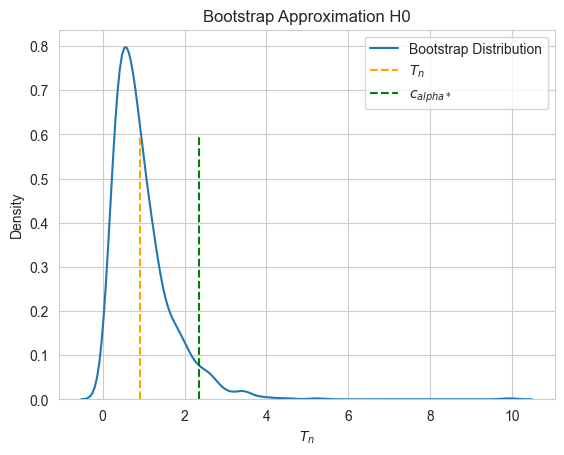

In [7]:
# Generate observational data
y1, y2 = generate_data_franke(defect=False)

BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H0 =BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
BS.plot_kde(title="Bootstrap Approximation H0")

100%|██████████| 1000/1000 [00:04<00:00, 238.88it/s]


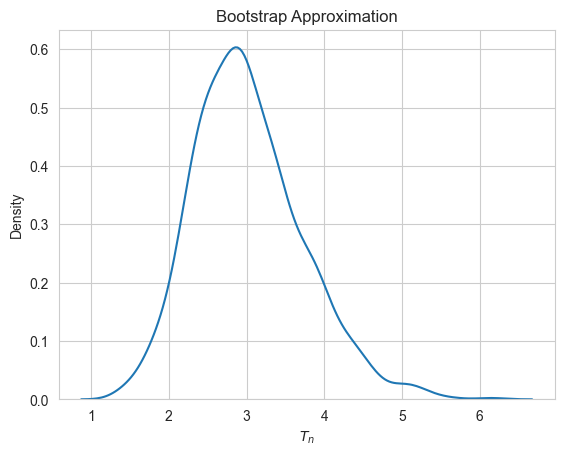

In [129]:
MC = MonteCarlo(kernel_function="bartlett_priestley_kernel")
Tn_monte = MC.compute_Tn(h=.02, M=1000)

# run & plot
fig, ax = plt.subplots()
sns.kdeplot(Tn_monte, ax=ax)
ax.set_xlabel(r"$T_n$")
ax.set_title("Bootstrap Approximation")
plt.show()

Defects: $H_1: m_I$ != $m_{II}$

100%|██████████| 1000/1000 [00:04<00:00, 243.45it/s]


The Hypothesis H0 was rejected
c_alpha_star is 3.9274


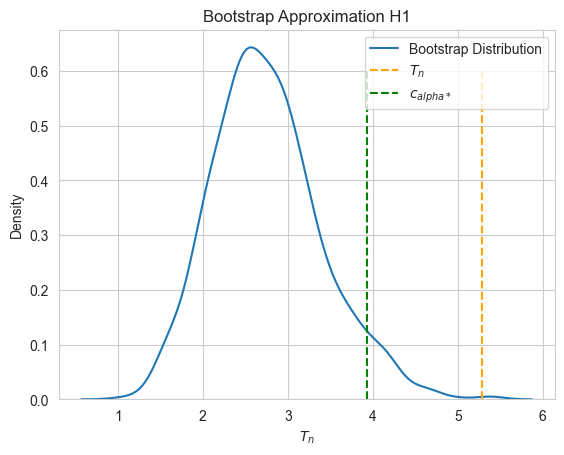

In [16]:
# Generate observational data
y1, y2 = generate_data_franke()

BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H1 = BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
BS.plot_kde(title="Bootstrap Approximation H1")

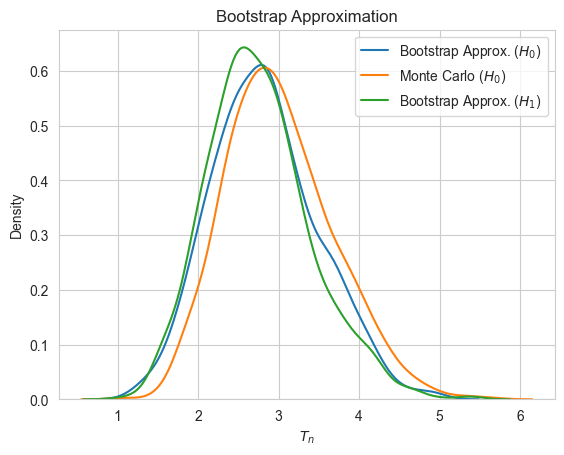

In [17]:
fig, ax = plt.subplots()
sns.kdeplot(results_H0["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_0$)")
sns.kdeplot(Tn_monte, ax=ax, label=r"Monte Carlo ($H_0$)")
sns.kdeplot(results_H1["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_1$)")
#ax.vlines(results_H0["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="orange", label=r"$T_n H_0$")
#ax.vlines(results_H1["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="green", label=r"$T_n H_1$")

#sns.kdeplot(Tn_monte_H1, ax=ax, label=r"Monte Carlo ($H_1$)")
ax.set_xlabel(r"$T_n$")
ax.set_title("Bootstrap Approximation")
ax.legend()
plt.show()

# Wild vs Classic Bootstrap

In [55]:
def iter(i):
    np.random.seed(i)
    # Generate observational data
    y1, y2 = generate_data_franke()

    BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
    results_wild = BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
    #BS.plot_kde(title="Bootstrap Approximation Wild")

    BS = Bootstrap(method="classic", kernel_function="bartlett_priestley_kernel")
    results_classical = BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
    #BS.plot_kde(title="Bootstrap Approximation Classic")
    return [results_wild["rejected"], results_classical["rejected"]]

from tqdm import trange
pool = Pool(mp.cpu_count()-1)
L = 50

DATA = np.zeros((L, 2))
for i in trange(L):
    DATA[i] = iter(i)


  0%|          | 0/70 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [41]:
print(pd.DataFrame(np.sum(DATA, axis=0), index = ['wild resampling rejected', 'classic resampling rejected']))

                                0
wild resampling rejected     66.0
classic resampling rejected  67.0


# Examination

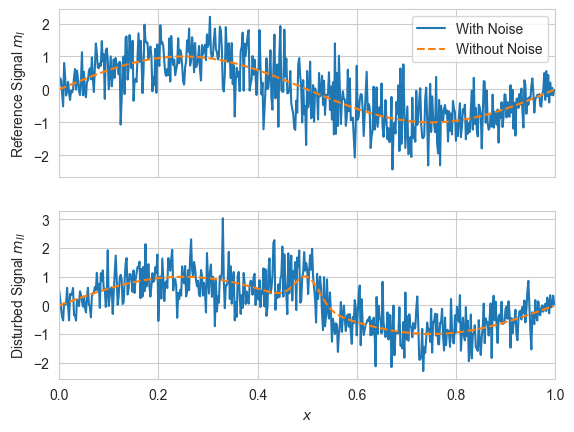

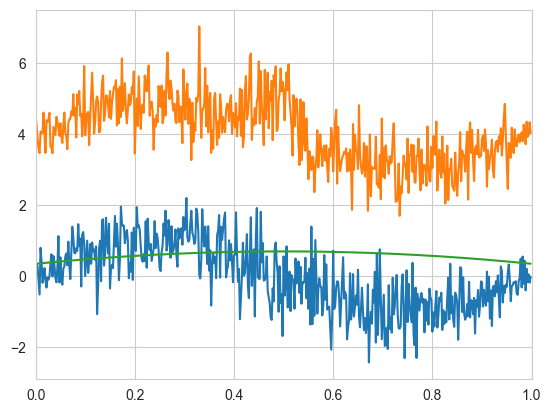

In [25]:
# plotting generated signals
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)
y1, y2 = generate_synthetic_data(m1, m2, sigma)
y1_clean, y2_clean = generate_synthetic_data(m1, m2, 0)

#plt.figure(dpi=600)
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(x, y1)
axs[0].plot(x, y1_clean, "--")
axs[0].set_ylabel(r"Reference Signal $m_I$")
axs[1].plot(x, y2)
axs[1].plot(x, y2_clean, "--")
axs[1].set_ylabel(r"Disturbed Signal $m_{II}$")
axs[1].set_xlabel(r"$x$")
axs[0].legend(["With Noise", "Without Noise"])
plt.xlim([0, 1])
plt.show()

plt.plot(x, y1)
plt.plot(x, y2+4)
plt.plot(x, sigma)
plt.xlim([0, 1])
plt.show()

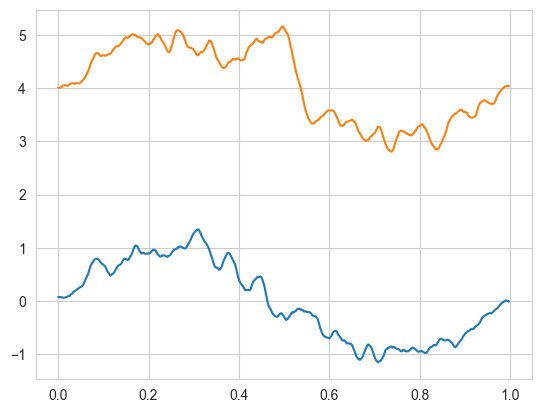

In [26]:
# plotting smoothed estimates
m1 = calc_smoothed_estimate(y1, bartlett_priestley_kernel, h=0.02)
m2 = calc_smoothed_estimate(y2, bartlett_priestley_kernel, h=0.02)
plt.plot(x, m1)
plt.plot(x, m2+4)
# plt.plot(x,np.square(m1-m2))
# np.sum(np.square(m1-m2))*np.sqrt(0.02)
plt.show()

# Test 2D Image

In [2]:
folders = ["no_defect_images", "defect_images"]
X,X_hat = load_images(folders, target_size=(100, 100))
y = X_hat[1]

Processing Rows: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


True (16, 2) (42, 81)


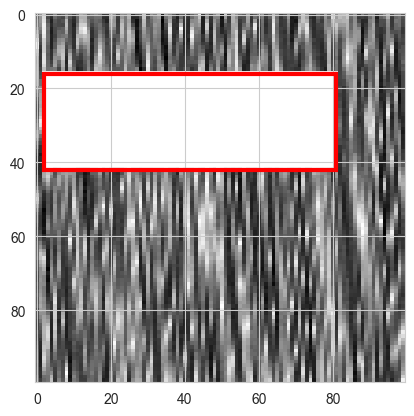

In [3]:
BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
defect, minpoint, maxpoint =BS.test_image(X[0],y, B = 50, h= 0.02, g = 0.04)
print(defect, minpoint, maxpoint)
plot_defect_area(y, minpoint, maxpoint)

# Old Snippets

In [ ]:
epsilon_hat = np.random.random_sample(10)
x_all = np.zeros((1000000, 10))
for i in range(1000000):
    x_all[i, :] = get_wild_residual_normal(epsilon_hat)
print(np.square(epsilon_hat))
print(np.power(epsilon_hat, 3))
print(np.mean(x_all, axis=0))
print(np.mean(np.square(x_all), axis=0))
print(np.mean(np.power(x_all, 3), axis=0))

In [ ]:
import matplotlib.pyplot as plt 
N = 500
x = np.arange(N)/N
y = np.sin(np.pi * 2* x) + np.exp((-800)*np.power(x-0.5, 2))
m = smoothed_estimate(y, bartlett_priestley_kernel, h=0.2)

plt.figure(dpi=600)
plt.plot(x, y)
plt.plot(x, m)
plt.title("Test for smoothed estimate")
plt.legend(["y", "m"])
plt.show()